In [1]:
import pandas as pd
from sklearn import metrics
df = pd.read_csv('stats_section_cleaned_anzctr_small.txt',delimiter='\t',encoding = "ISO-8859-1")
stop_words = pd.read_csv('stops.csv', header = None)
stop_words=set(stop_words.iloc[:,0])

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   number           98 non-null     object
 1   text_data_clean  98 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


In [3]:
df['text_data_clean'] = df[['text_data_clean','number']].groupby(['number'])['text_data_clean'].transform(lambda x: ','.join(x))
df = df[['text_data_clean','number']].drop_duplicates()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text_data_clean  98 non-null     object
 1   number           98 non-null     object
dtypes: object(2)
memory usage: 2.3+ KB


In [5]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
punct.remove("-")

def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

def stat_tokenizer(document):
    tokens = []
    for sent in sent_tokenize(document):
        for token, tag in pos_tag(word_tokenize(sent)):
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            if token in stop_words:
                continue
            if all(char in punct for char in token):
                continue
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

def no_lem_tokenize(document):
    tokens = []
    for sent in sent_tokenize(document):
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            tokens.append(token)
    return tokens

def data_prep(document):
    filtered_sentence = []
    word_tokens = word_tokenize(document)
    document = listToString(document)       
    punctuations = '''’”つ。\“「」「」!()[]{};:'"\,<>./?@#$%^&*_~'''
    for x in document: 
        if x in punctuations: 
            document = document.replace(x, "") 
    word_tokens = word_tokenize(document)     
    filtered_sentence = [] 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence   

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(tokenizer=stat_tokenizer)
X = tfidf_vec.fit_transform(df['text_data_clean'])
feature_names = tfidf_vec.get_feature_names()
    

print(len(tfidf_vec.get_feature_names()))

1417


In [7]:
import sklearn
def check_number_of_labels(n_labels, n_samples):
    """Check that number of labels are valid.
    Parameters
    ----------
    n_labels : int
        Number of labels
    n_samples : int
        Number of samples
    """
    if not 1 < n_labels < n_samples:
        raise ValueError("Number of labels is %d. Valid values are 2 "
                         "to n_samples - 1 (inclusive)" % n_labels)
        
def calinski_harabasz_score(X, labels):
    """Compute the Calinski and Harabasz score.
    It is also known as the Variance Ratio Criterion.
    The score is defined as ratio between the within-cluster dispersion and
    the between-cluster dispersion.
    Read more in the :ref:`User Guide <calinski_harabasz_index>`.
    Parameters
    ----------
    X : array-like, shape (``n_samples``, ``n_features``)
        List of ``n_features``-dimensional data points. Each row corresponds
        to a single data point.
    labels : array-like, shape (``n_samples``,)
        Predicted labels for each sample.
    Returns
    -------
    score : float
        The resulting Calinski-Harabasz score.
    References
    ----------
    .. [1] `T. Calinski and J. Harabasz, 1974. "A dendrite method for cluster
       analysis". Communications in Statistics
       <https://www.tandfonline.com/doi/abs/10.1080/03610927408827101>`_
    """
    #X, labels = check_X_y(X, labels)
    le = sklearn.preprocessing.LabelEncoder()
    labels = le.fit_transform(labels)

    n_samples, _ = X.shape
    n_labels = len(le.classes_)

    check_number_of_labels(n_labels, n_samples)

    extra_disp, intra_disp = 0., 0.
    mean = np.mean(X, axis=0)
    for k in range(n_labels):
        cluster_k = X[labels == k]
        mean_k = np.mean(cluster_k, axis=0)
        extra_disp += len(cluster_k) * np.sum((mean_k - mean) ** 2)
        intra_disp += np.sum((cluster_k - mean_k) ** 2)
    extra_disp = extra_disp * (n_samples - n_labels)
    intra_disp = intra_disp * (n_labels - 1.)
    return (extra_disp, intra_disp)

In [8]:
from sklearn.decomposition import NMF
import numpy as np
import warnings
warnings.filterwarnings("ignore")
max_rank = 50
sil_score = []
extra_disp = []
intra_disp = []

for rank in range(2,max_rank+1):
    print("rank:", rank)
    nmf = NMF(n_components=rank, random_state=1).fit(X)
    W = nmf.fit_transform(X) # W is the document factor matrix doc x rank
    labels = W.argmax(axis = 1)
    sil_score.append(metrics.silhouette_score(W, labels, metric='euclidean'))
    a,b = calinski_harabasz_score(W, labels)
    extra_disp.append(a)
    intra_disp.append(b)

rank: 2
rank: 3
rank: 4
rank: 5
rank: 6
rank: 7
rank: 8
rank: 9
rank: 10
rank: 11
rank: 12
rank: 13
rank: 14
rank: 15
rank: 16
rank: 17
rank: 18
rank: 19
rank: 20
rank: 21
rank: 22
rank: 23
rank: 24
rank: 25
rank: 26
rank: 27
rank: 28
rank: 29
rank: 30
rank: 31
rank: 32
rank: 33
rank: 34
rank: 35
rank: 36
rank: 37
rank: 38
rank: 39
rank: 40
rank: 41
rank: 42
rank: 43
rank: 44
rank: 45
rank: 46
rank: 47
rank: 48
rank: 49
rank: 50


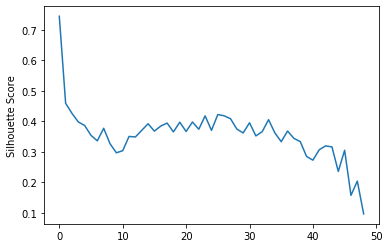

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(sil_score)
plt.ylabel('Silhouette Score')
plt.show()

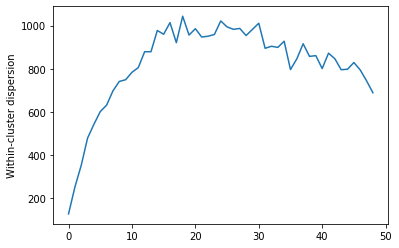

In [10]:
 plt.plot(extra_disp)
plt.ylabel('Within-cluster dispersion')
plt.show()

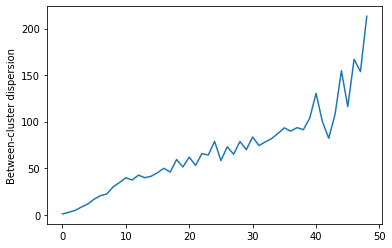

In [11]:
plt.plot(intra_disp)
plt.ylabel('Between-cluster dispersion')
plt.show()

In [12]:
from sklearn.decomposition import NMF
import numpy as np
# NMF with optimal K
optimal_rank = 2 # say 2 is optimal
nmf = NMF(n_components=optimal_rank, random_state=1).fit(X)

In [13]:
W = nmf.fit_transform(X) # W is the document factor matrix doc x rank
H = nmf.components_ # H is the term factor matrix  rank x term

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text_data_clean  98 non-null     object
 1   number           98 non-null     object
dtypes: object(2)
memory usage: 2.3+ KB


In [15]:
import numpy as np
np.shape(H)

(2, 1417)

In [16]:
H[1,:]

array([0.        , 0.02920066, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [17]:
DoIs = df['number']
DoI = pd.DataFrame(DoIs)
DoI.columns=['DOI']
DoI['clusterID'] = np.argmax(W, axis = 1)+1
DoI['value'] = np.amax(W, axis = 1)
DoI

,DOI,clusterID,value
0,ACTRN12613000009718,1,0.184266
1,ACTRN12613000016730,1,0.043623
2,ACTRN12613000021774,1,0.247173
3,ACTRN12613000024741,1,0.062061
4,ACTRN12613000030774,1,0.176731
...,...,...,...
93,ACTRN12613000238774,1,0.093598
94,ACTRN12613000239763,1,0.094604
95,ACTRN12613000240741,1,0.108165
96,ACTRN12613000241730,1,0.088931


In [18]:
# how many in each
print("Cluster membership")
print(DoI['clusterID'].value_counts())

Cluster membership
1    90
2     8
Name: clusterID, dtype: int64


In [19]:
import warnings
warnings.filterwarnings("ignore")
# For each cluster/topic identify top 10 DoIs.
top_n = 10
for i in range(1, optimal_rank+1):
    DoI2 = DoI[DoI['clusterID']==i]
    DoI2.sort_values('value', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
    top_titl = '\n\nTopic '+str(i)
    print(top_titl)
    DoI2.index = np.arange(1,len(DoI2)+1)
    print(DoI2.head(top_n))



Topic 1
                    DOI  clusterID     value
1   ACTRN12613000125729          1  0.296656
2   ACTRN12613000130763          1  0.296046
3   ACTRN12613000115730          1  0.285410
4   ACTRN12613000095763          1  0.272388
5   ACTRN12613000046707          1  0.270460
6   ACTRN12613000228785          1  0.270326
7   ACTRN12613000105741          1  0.263034
8   ACTRN12613000108718          1  0.261720
9   ACTRN12613000109707          1  0.252026
10  ACTRN12613000021774          1  0.247173


Topic 2
                   DOI  clusterID     value
1  ACTRN12613000180718          2  0.700180
2  ACTRN12613000076774          2  0.687991
3  ACTRN12613000142730          2  0.567568
4  ACTRN12613000213741          2  0.356867
5  ACTRN12613000145707          2  0.332514
6  ACTRN12613000149763          2  0.309089
7  ACTRN12613000088741          2  0.298986
8  ACTRN12613000193774          2  0.119476


In [20]:
n_top_words = 100
feature_names = tfidf_vec.get_feature_names()
for topic_idx, topic in enumerate(nmf.components_):
    top_titl = '\n\nTopic '+str(topic_idx+1)
    print(top_titl)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()



Topic 1
will analysis outcome data variable measure percent study test group difference model baseline compare treatment analyse intention-to-treat mean participant intervention between t-test between-group primary effect mixed perform regression change continuous time patient anova include conduct statistical demographic categorical statistic secondary assess chi-square report control s examine repeated comparison descriptive month describe level confidence significant sample independent interval distribute estimate non-parametric consider number score determine standard 95 linear normally - basis appropriate size median 3 base factor significance trial deviation rate p-value characteristic analysis-of-variance less-than present after age 0.05 end 6 event summary method miss multiple calculate power distribution repeat student



Topic 2
spss will software statistical statistician ibm science social data statistically package inc. window v18.0 11.5 v. analyse p consultation less-tha

In [21]:
print('Size of the topic ''(''number of terms out of total terms (35881))')
num_of_terms = []
terms_in_topics = []
for i in range(0,optimal_rank):
    top_titl = '\n\nTopic '+str(i+1)
    num_of_terms.append([y for y in  nmf.components_[i] if y>0])
    terms_in_topics.append(len(num_of_terms[i]))
    print(top_titl, ':',len(num_of_terms[i]))


Size of the topic (number of terms out of total terms (35881))


Topic 1 : 1407


Topic 2 : 237


In [22]:
dd = pd.DataFrame(terms_in_topics,columns=['#terms'])
dd['topic'] = np.arange(1,len(dd)+1)
dd

,#terms,topic
0,1407,1
1,237,2


Text(0.5, 0, 'Topic')

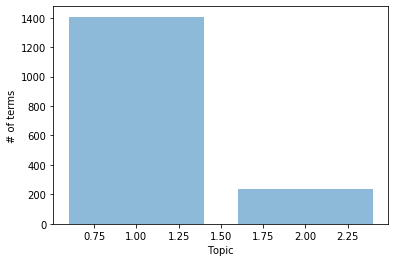

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.bar(dd['topic'],dd['#terms'], align='center', alpha=0.5)
plt.ylabel('# of terms')
plt.xlabel('Topic')

In [24]:
from scipy import stats
print('Total number of words:', '35881')
print('Median number of words by topic:', dd['#terms'].median())
# Interquartile range (IQR) 
IQR = stats.iqr(dd['#terms'], interpolation = 'midpoint') 
print('IQR of words by topic:', IQR)

Total number of words: 35881
Median number of words by topic: 822.0
IQR of words by topic: 0.0


In [25]:
topic_words = []
topic_values = []
for i in range(0,optimal_rank):
    topic_words.append([feature_names[i] for i in nmf.components_[i].argsort()[:-n_top_words - 1 :-1]])
    topic_values.append([nmf.components_[i][j] for j in nmf.components_[i].argsort()[:-n_top_words - 1 :-1]])

In [26]:
nmf.components_[i].argsort()[:-n_top_words - 1 :-1]

array([1212, 1399, 1203, 1220, 1222,  613, 1140, 1201,  366, 1221,  895,
        632, 1400, 1356,   19, 1355,  136,  892,  323,  727, 1184,    6,
        464,  287,  164,  381,   34,  318, 1281,  258,  618,   43, 1321,
        195,  712, 1371, 1264, 1345,  235,  922, 1090, 1235,  549,    1,
        304,  190,  794,  339,   42,  777,  422,  853,  767,   26,  144,
        236,   33,   48,   23,  138,  643,  227, 1164, 1028,  397,  382,
       1324,  408,  140,  893, 1012, 1183,  779, 1260,  582,  231,  256,
        407,  920, 1034,  588,  536, 1219, 1036,  458,  421,  914, 1353,
       1279, 1195,    7,  948,  846,  404,  830,  790,  878,  403, 1286,
       1153], dtype=int64)

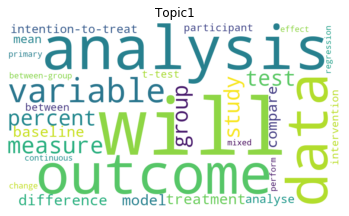

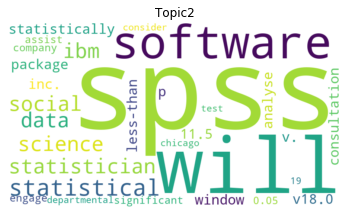

In [27]:
# Generating the wordcloud with the values under the category dataframe
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
for i in range(0,optimal_rank):
    titl = 'Topic'+str(i+1)
    d = {}
    for q in range(0,len(topic_words[i])):
        a = topic_words[i][q]
        #print(a)
        d[topic_words[i][q]] = topic_values[i][q]
    
    wordcloudi = WordCloud(background_color='white',width=900,height=500, max_words=30,relative_scaling=0,normalize_plurals=False).generate_from_frequencies(frequencies = d)
    plt.imshow(wordcloudi, interpolation='bilinear')
    plt.axis("off")
    plt.title(titl)
    plt.show()